# Introduction to Copulas
## Probability Review
Let's start by reviewing some basic probability concepts. We'll focus specifically on continuous random variables, which is what the Copulas library is primarily intended to support.

In [1]:
%matplotlib inline
import warnings
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
N = 10000
warnings.filterwarnings("ignore")

### Probability Density Function
A probability density function $f(x)$ captures the likelihood that a random sample from the distribution is equal to $x$. For example, the probability density function for the standard normal distribution is given by

\begin{equation}
f(x) = \frac{1}{2 \pi} e^{-x^2/2}
\end{equation}

Note that the probability density function does **not** return a probability but rather a "relative likelihood" which can take on values in the interval $[0, \infty)$; however, the integral over the probability density function from $-\infty$ to $\infty$ must be equal to one.

### Cumulative Distribution Function
In many cases, the probability density function can be hard to work with directly. Instead, we will use the cumulative distribution function $F(x)$ which is defined as the integral of the probability density function

\begin{equation}
F(x) = \int_{-\infty}^x f(x)
\end{equation}

The below figure shows the probability density function $f(x)$ and the cumulative distribution function $F(x)$ for a normal distribution with mean $0.0$ and variance $0.25$.

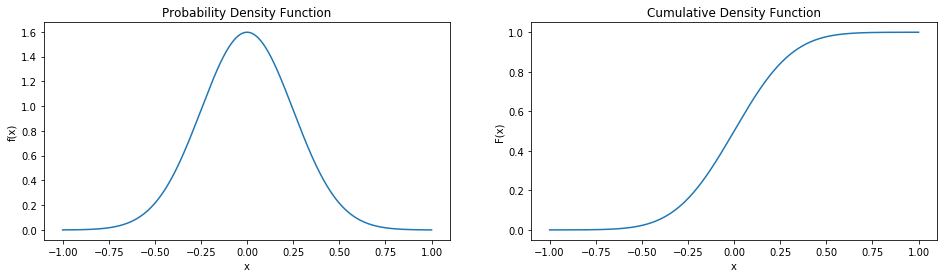

In [2]:
x = np.linspace(-1.0, 1.0, N)

figure = plt.figure(figsize=(16,4))
figure.add_subplot(1, 2, 1)
plt.plot(x, stats.norm.pdf(x, loc=0.0, scale=0.25))
plt.title("Probability Density Function")
plt.xlabel("x")
plt.ylabel("f(x)")

figure.add_subplot(1, 2, 2)
plt.plot(x, stats.norm.cdf(x, loc=0.0, scale=0.25))
plt.title("Cumulative Density Function")
plt.xlabel("x")
plt.ylabel("F(x)")

plt.show();

### Probability Integral Transform
The probability integral transform is a key component in our toolkit for working with probability distributions. Suppose we have a random variable $X$ that comes from a distribution with cumulative density function $F(X)$. Then, we can define a random variable $Y$ as

\begin{equation}
Y = F(X)
\end{equation}

and prove that $Y$ follows a uniform distribution over the interval $[0.0, 1.0]$. The below figure shows an example of this. We sample some data from a normal distribution and plot it on the left. Then, we use the CDF of the normal distribution to transform the data, plot it on the right, and observe that it resembles an uniform distribution.

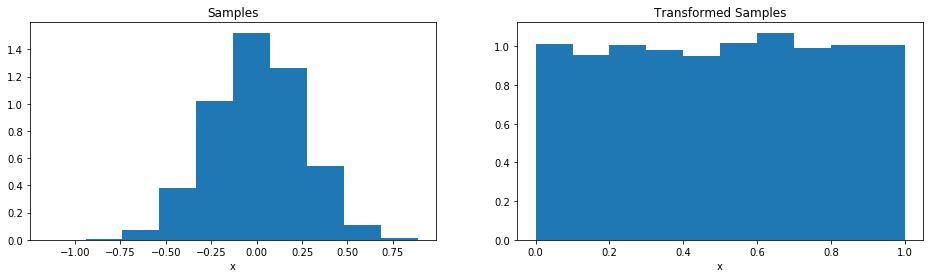

In [3]:
X = stats.norm.rvs(size=N, loc=0.0, scale=0.25)
X_pit = stats.norm.cdf(X, loc=0.0, scale=0.25)

figure = plt.figure(figsize=(16,4))
figure.add_subplot(1, 2, 1)
plt.hist(X, density=True, bins=10)
plt.title("Samples")
plt.xlabel("x")

figure.add_subplot(1, 2, 2)
plt.hist(X_pit, density=True, bins=10)
plt.title("Transformed Samples")
plt.xlabel("x")

plt.show();

## Basic Copulas
The key intuition underlying copula functions is the idea that marginal distributions can be modeled independently from the joint distribution. For example, consider a dataset with two columns containing age and income. A copula-based modeling approach would:

1. Model age and income independently, transforming them into uniform distributions using the *probability integral transform* explained above.
2. Model the relationship between the transformed variables using the copula function.

In this section, we demonstrate a simplified example of a Gaussian copula.

In [15]:
import pandas as pd
from scipy.stats import beta, norm
N = 500
age = beta.rvs(a=2.0, b=6.0, loc=18, scale=100, size=N)
income = np.log(age)*100 + \
            np.random.normal(loc=100, scale=300, size=N) * \
                (10 * norm(loc=40, scale=50).pdf(age) / \
                 np.sum(norm(loc=40, scale=50).pdf(age)))
income[np.random.randint(0,10, size=N)==0] /= 1000
df = pd.DataFrame({
    "age": age,
    "income": income
})

Text(0, 0.5, 'Income')

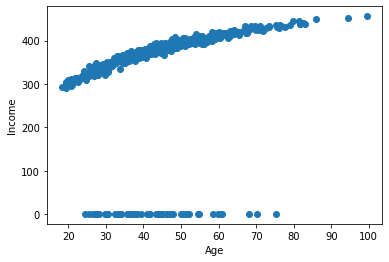

In [16]:
plt.scatter(df["age"], df["income"])
plt.xlabel("Age")
plt.ylabel("Income")

Here's what the age and income variables look like separately.

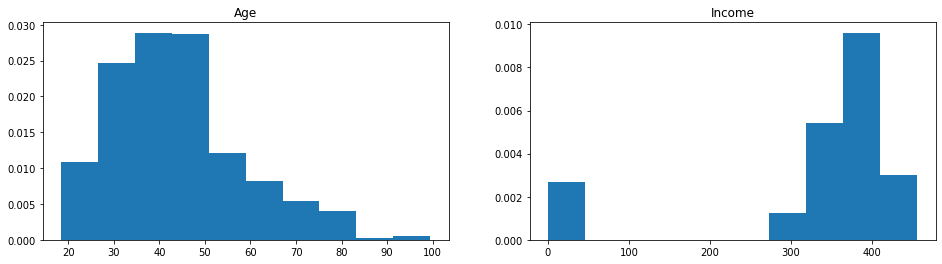

In [17]:
x = np.linspace(-1.0, 1.0, N)

figure = plt.figure(figsize=(16,4))
figure.add_subplot(1, 2, 1)
plt.hist(df["age"], density=True)
plt.title("Age")

figure.add_subplot(1, 2, 2)
plt.hist(df["income"], density=True)
plt.title("Income")

plt.show();

To model this using a Gaussian copula, we can simply run the following:

In [18]:
from copulas.multivariate import GaussianMultivariate
copula = GaussianMultivariate()
copula.fit(df)

The GaussianMultivariate class will automatically transform the columns using the best available distribution; let's take a look at what the transformed age and income variables look like.

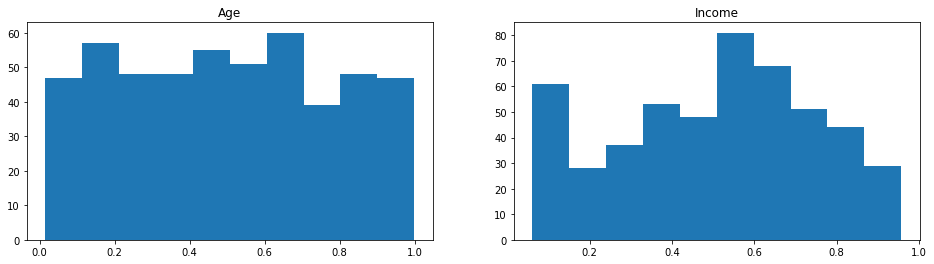

In [19]:
x = np.linspace(-1.0, 1.0, N)

figure = plt.figure(figsize=(16,4))
figure.add_subplot(1, 2, 1)
plt.hist(copula.univariates[0].cdf(df["age"]))
plt.title("Age")

figure.add_subplot(1, 2, 2)
plt.hist(copula.univariates[1].cdf(df["income"]))
plt.title("Income")

plt.show();

Note that this transformed data looks much more uniform than the original values. Using this transformed data, we can then model the relationship between age and income more easily and generate some synthetic data.

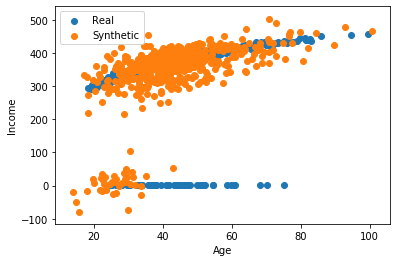

In [20]:
synthetic = copula.sample(N)
plt.scatter(df["age"], df["income"], label="Real")
plt.scatter(synthetic["age"], synthetic["income"], label="Synthetic")
plt.xlabel("Age")
plt.ylabel("Income")
plt.legend();